In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import os
%matplotlib inline

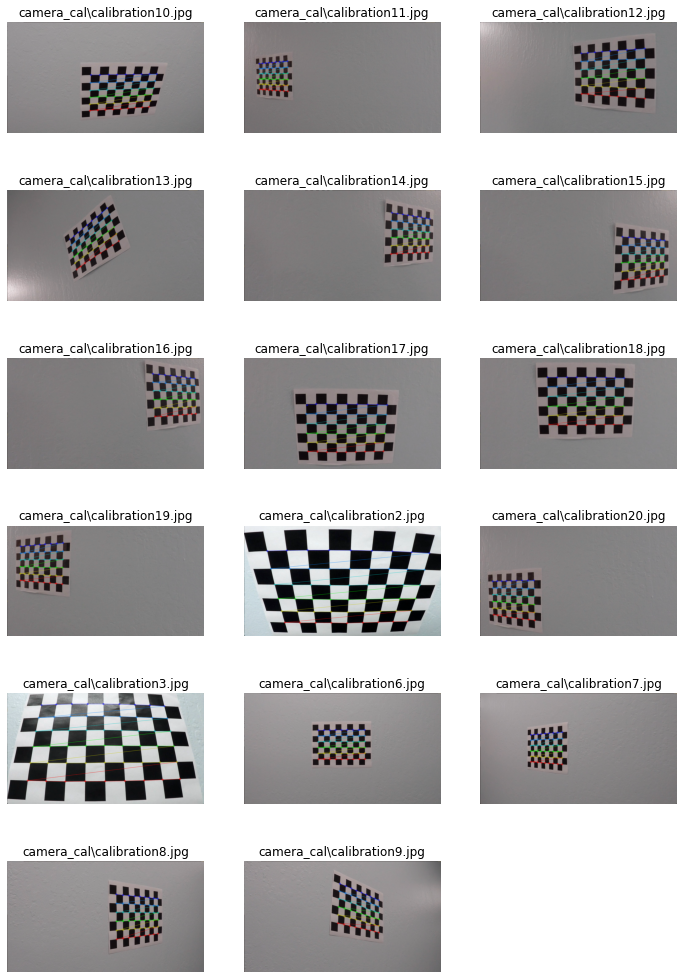

Corners were found on 17 out of 20


In [2]:
n_x = 9 #Number of corners to find
n_y = 6
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((n_y*n_x,3), np.float32)
objp[:,:2] = np.mgrid[0:n_x, 0:n_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('camera_cal/calibration*.jpg') # Make a list of paths to calibration images

plt.figure(figsize=(12, 18)) 

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Conver to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (n_x,n_y), None) # Find the chessboard corners
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (n_x, n_y), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')

plt.show()

print ('Corners were found on', str(len(imgpoints)), 'out of', str(len(images)))


Text(0.5, 1.0, 'Undistorted Image')

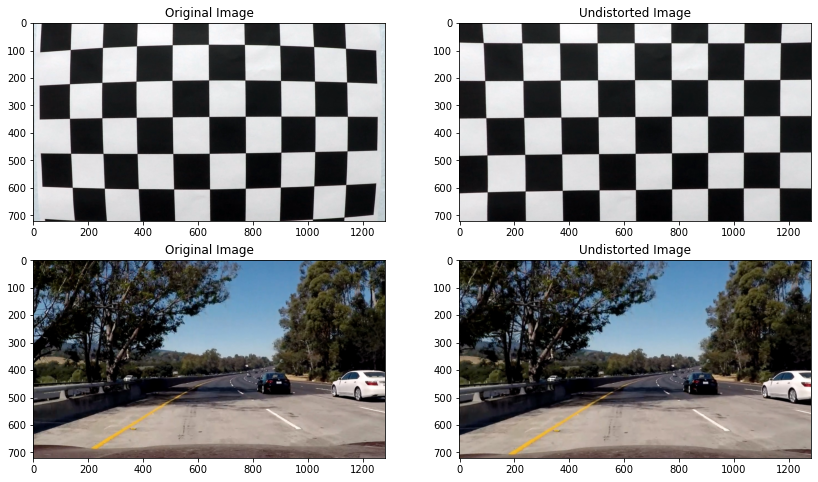

In [3]:
# Undistortion process
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted Image")
img = cv2.imread('test_images/test5.jpg')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")



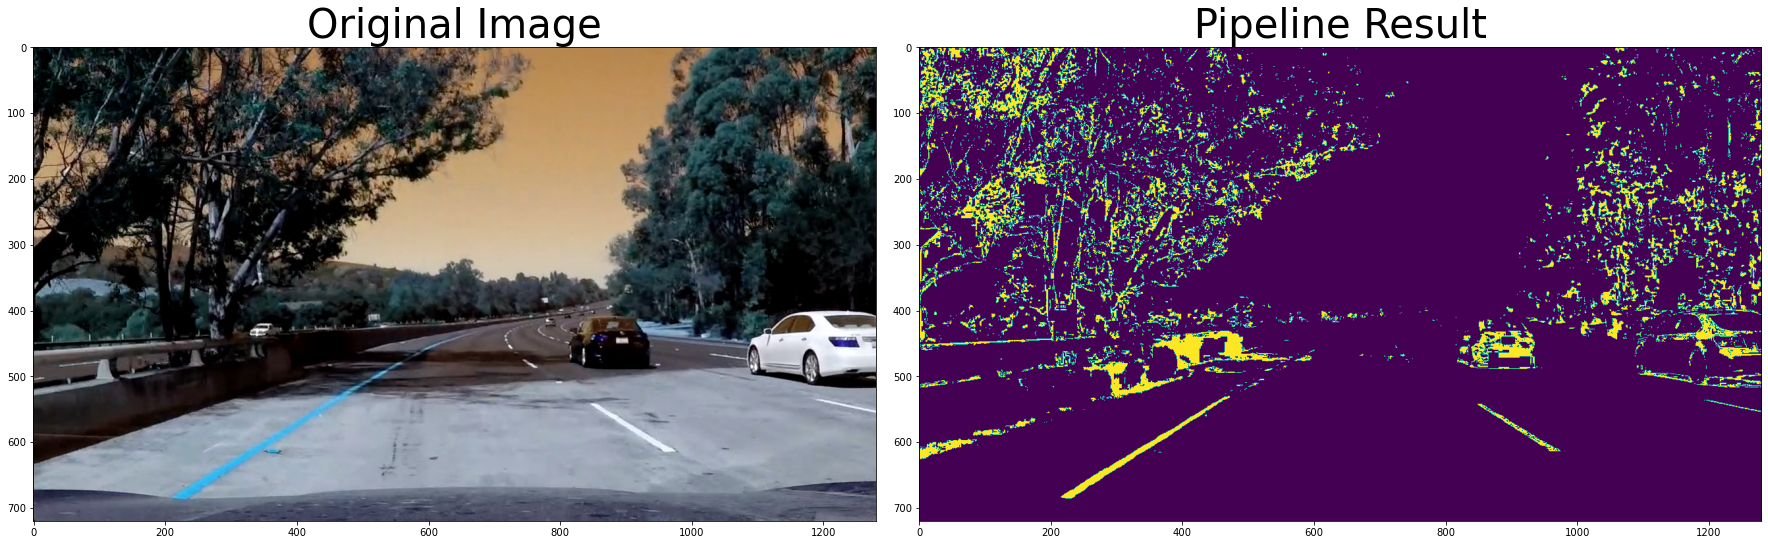

In [4]:
image = cv2.imread('test_images/test5.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return s_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

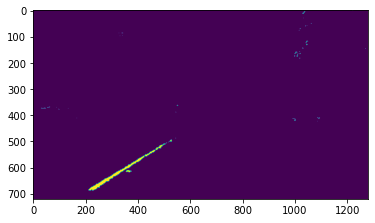

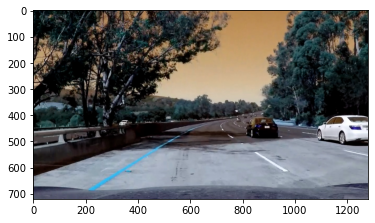

In [5]:
testimg = cv2.imread('test_images/test5.jpg')
#testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(testimg, cv2.COLOR_BGR2HSV)

lower = np.array([20, 100, 100])
upper = np.array([30, 255, 255])

mask = cv2.inRange(hsv, lower, upper)
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(testimg)

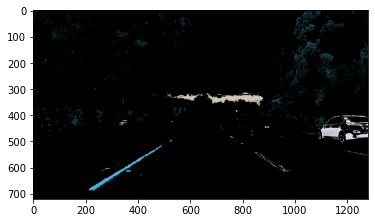

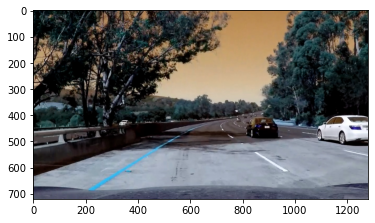

In [6]:
hls = cv2.cvtColor(testimg, cv2.COLOR_BGR2HLS)

# White-ish areas in image
# H value can be arbitrary, thus within [0 ... 360] (OpenCV: [0 ... 180])
# L value must be relatively high (we want high brightness), e.g. within [0.7 ... 1.0] (OpenCV: [0 ... 255])
# S value must be relatively low (we want low saturation), e.g. within [0.0 ... 0.3] (OpenCV: [0 ... 255])
white_lower = np.array([np.round(  0 / 2), np.round(0.75 * 255), np.round(0.00 * 255)])
white_upper = np.array([np.round(360 / 2), np.round(1.00 * 255), np.round(0.30 * 255)])
white_mask = cv2.inRange(hls, white_lower, white_upper)

# Yellow-ish areas in image
# H value must be appropriate (see HSL color space), e.g. within [40 ... 60]
# L value can be arbitrary (we want everything between bright and dark yellow), e.g. within [0.0 ... 1.0]
# S value must be above some threshold (we want at least some saturation), e.g. within [0.35 ... 1.0]
yellow_lower = np.array([np.round( 40 / 2), np.round(0.00 * 255), np.round(0.35 * 255)])
yellow_upper = np.array([np.round( 60 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
yellow_mask = cv2.inRange(hls, yellow_lower, yellow_upper)

# Calculate combined mask, and masked image
mask = cv2.bitwise_or(yellow_mask, white_mask)
masked = cv2.bitwise_and(testimg, testimg, mask = mask)

plt.figure()
plt.imshow(masked)
plt.figure()
plt.imshow(testimg)

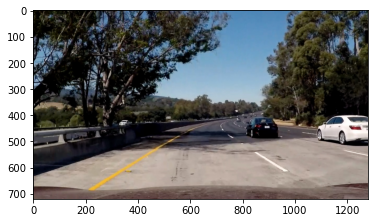

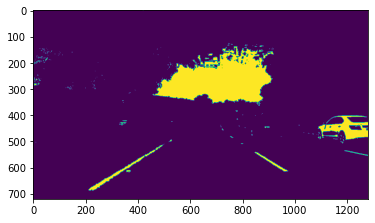

In [7]:
def bin_t(img, bin_th):
    out_img = np.zeros_like(img)
    out_img[(img >= bin_th[0]) & (img <= bin_th[1])] = 1
    return out_img


def img_col_sel(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    bin_th = [20, 255]
    #yellow mask rgb
    lower = np.array([255, 180, 0])
    upper = np.array([255, 255, 170])
    mask = cv2.inRange(img, lower, upper)
    yel_rgb = cv2.bitwise_and(img, img, mask=mask)
    yel_rgb = cv2.cvtColor(yel_rgb, cv2.COLOR_RGB2GRAY)
    yel_rgb = bin_t(yel_rgb, bin_th)
    
    #white mask rgb
    lower = np.array([100, 100, 200])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(img, lower, upper)
    w_rgb = cv2.bitwise_and(img, img, mask=mask)
    #plt.figure()
    #plt.imshow(w_rgb)
    w_rgb = cv2.cvtColor(w_rgb, cv2.COLOR_RGB2GRAY)
    w_rgb = bin_t(w_rgb, bin_th)
    
    #yellow mask hls
    lower = np.array([20, 100, 80])
    upper = np.array([45, 255, 255])
    mask = cv2.inRange(hls, lower, upper)
    yel_hls = cv2.bitwise_and(img, img, mask=mask)
    #plt.figure()
    #plt.imshow(yel_hls)
    yel_hls = cv2.cvtColor(yel_hls, cv2.COLOR_HLS2RGB)
    yel_hls = cv2.cvtColor(yel_hls, cv2.COLOR_RGB2GRAY)
    yel_hls = bin_t(yel_hls, bin_th)
    
    out_img = np.zeros_like(yel_hls)
    out_img[(yel_hls == 1) | (w_rgb == 1) | (yel_rgb == 1)] = 1
    
    return out_img

testimg = cv2.imread('test_images/test5.jpg')
testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
out = img_col_sel(testimg)
plt.figure()
plt.imshow(testimg)
plt.figure()
plt.imshow(out)

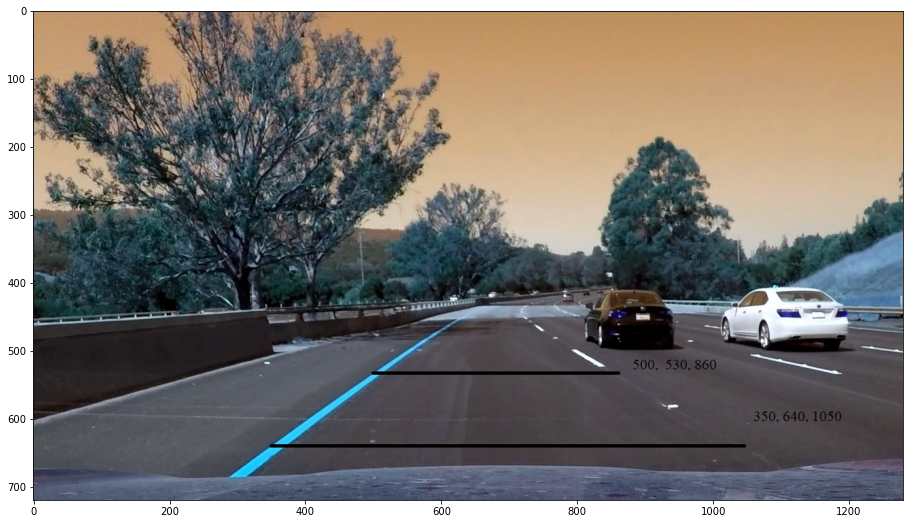

In [8]:
img = cv2.imread('transformation_points.jpg')
plt.figure(figsize=(24, 9))
plt.imshow(img)

<Figure size 432x288 with 0 Axes>

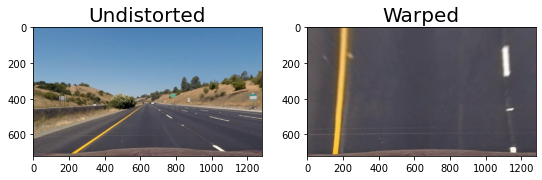

<Figure size 432x288 with 0 Axes>

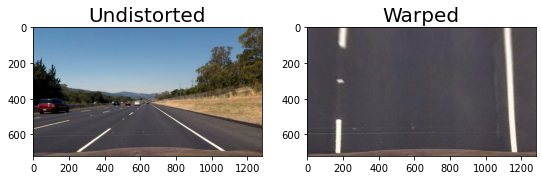

<Figure size 432x288 with 0 Axes>

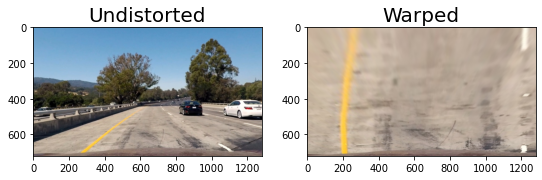

<Figure size 432x288 with 0 Axes>

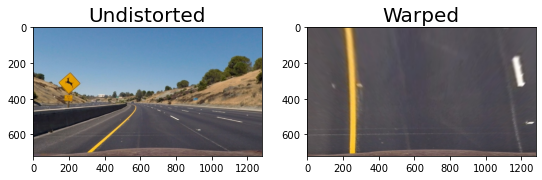

<Figure size 432x288 with 0 Axes>

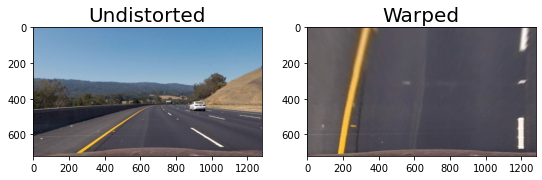

<Figure size 432x288 with 0 Axes>

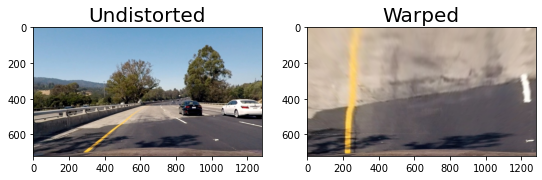

<Figure size 432x288 with 0 Axes>

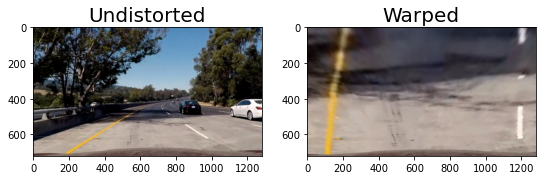

<Figure size 432x288 with 0 Axes>

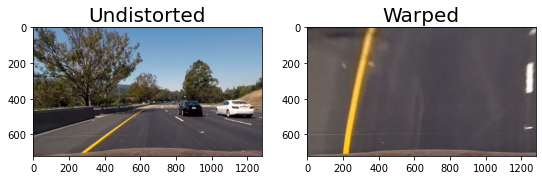

In [9]:
def transform(img, M):
    undist = undistort(img)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

def transform_inv(img, M):
    undist = undistort(img)
    img_size = (1280, 720)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

# Show original and warped image side by side
def show_warped(img, M):
    plt.figure()
    f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
    plot1.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
    plot1.set_title('Undistorted', fontsize=20)
    plot2.imshow(cv2.cvtColor(transform(img, M), cv2.COLOR_BGR2RGB))
    plot2.set_title('Warped', fontsize=20)
    
src = np.float32([[64, 720], [1216, 720], [768, 480], [512, 480]])
dst = np.float32([[0, 720], [1280, 720], [1280, 0], [0, 0]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

for imgname in os.listdir("test_images/"):
    img=cv2.imread('test_images/' + imgname)
    #plt.imshow(img)
    show_warped(img, M)
    

In [10]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 50
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img




def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, img):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 10
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
   
    # Fit a second order polynomial to each using `np.polyfit`
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        line = np.hstack((left_line_window1, right_line_window2))
        
        # Draw the lane onto the warped blank image
        #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([line]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        out = transform_inv(window_img, M_inv)
        result2 = cv2.addWeighted(img, 1, out, 0.3, 0)
        
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        
        left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
        # Calculate the position of the vehicle
        rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
        leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
        center = abs(640 - ((rightx_int+leftx_int)/2))
        font = cv2.FONT_HERSHEY_SIMPLEX
        if center < 640:
            #ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
             #    style='italic', color='white', fontsize=10)
            text = 'Vehicle is {:.2f}m left of center'.format(center*3.7/700)
            cv2.putText(result2, text, (50,50), font, 2, (255, 255, 255), 1, cv2.LINE_AA)
        else:
            #ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
            #     style='italic', color='white', fontsize=10)
            text = 'Vehicle is {:.2f}m right of center'.format(center*3.7/700)
            cv2.putText(result2, text, (50,50), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
            
        #ax2.text(200, 175, 'Left Lane Curve {}m'.format(int((left_curverad)),
         #    style='italic', color='white', fontsize=10)
        text = 'Left Lane Curve {}m'.format(int((left_curverad)))
        cv2.putText(result2, text, (50,125), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
                                            
        #ax2.text(200, 250, 'Right Lane Curve {}m'.format(int((left_curverad)),
            # style='italic', color='white', fontsize=10)
        text = 'Right Lane Curve {}m'.format(int((right_curverad)))
        cv2.putText(result2, text, (50,200), font, 2, (255, 255, 255), 2, cv2.LINE_AA)
        
    
        return result, result2
        
    except:
        pass

    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #print(left_line_pts)
    ## End visualization steps ##
    
    

<ipython-input-12-b8bf1de20c39>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


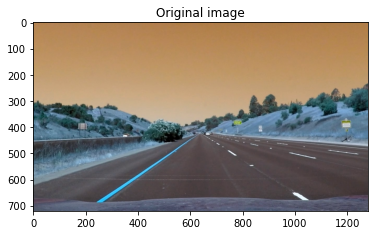

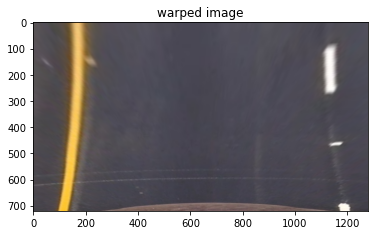

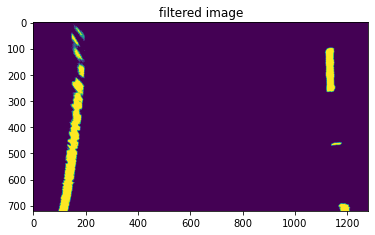

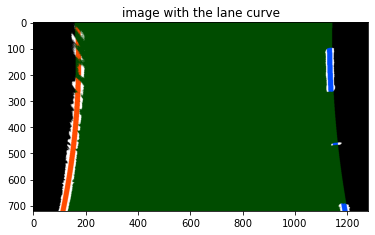

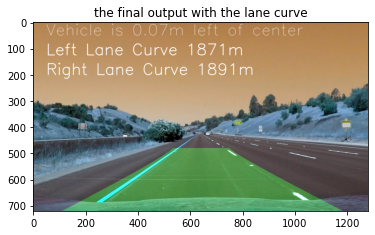

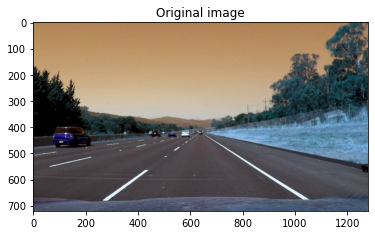

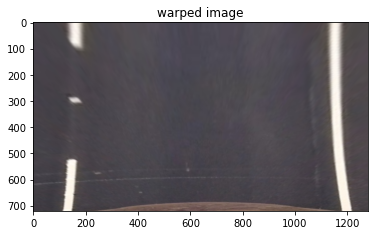

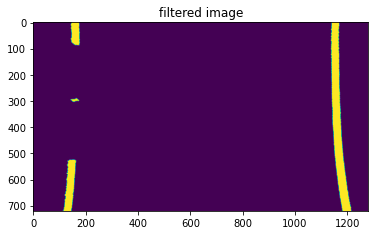

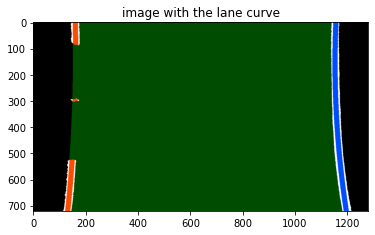

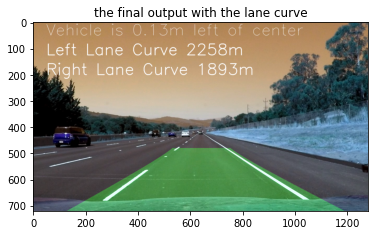

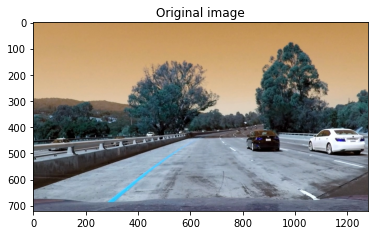

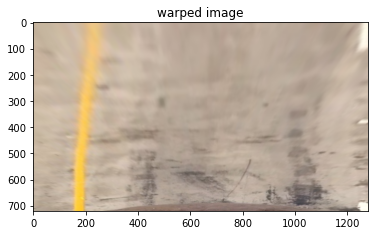

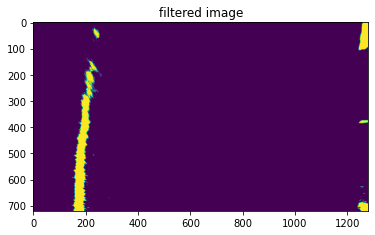

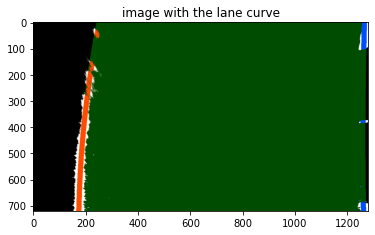

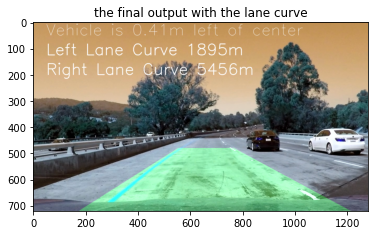

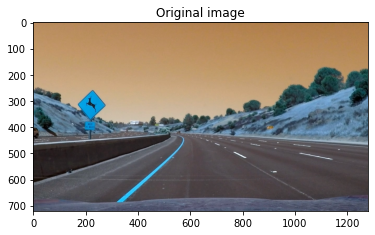

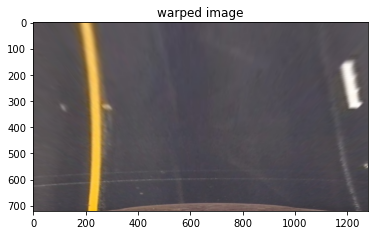

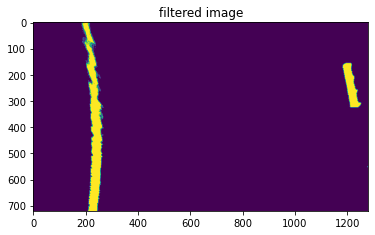

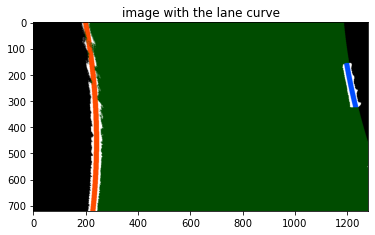

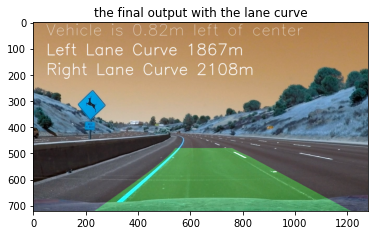

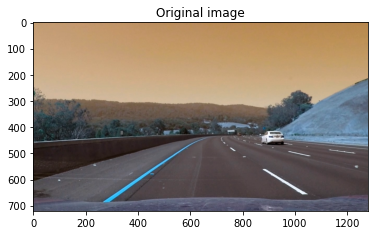

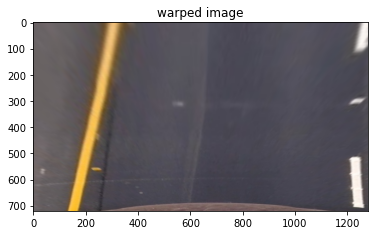

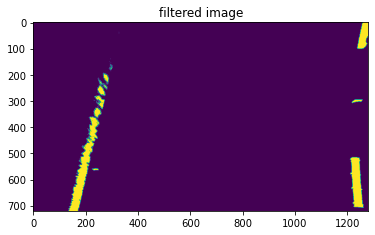

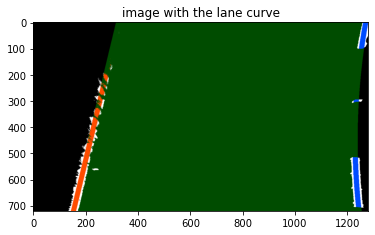

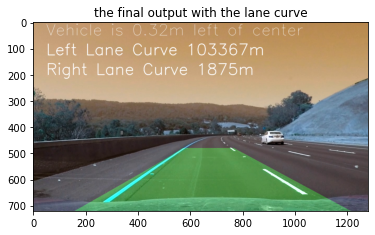

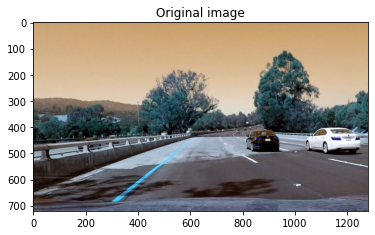

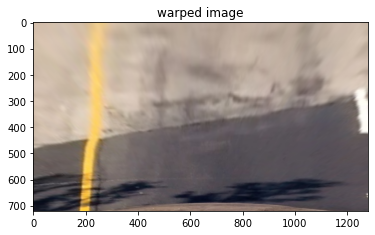

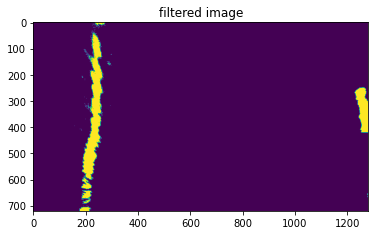

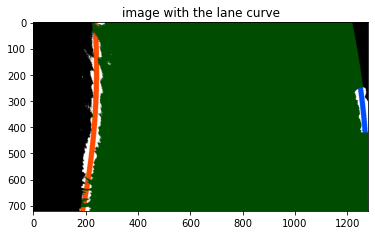

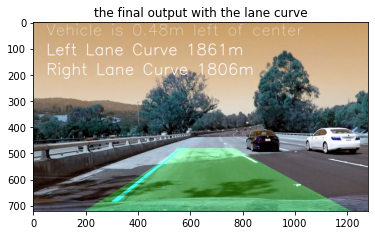

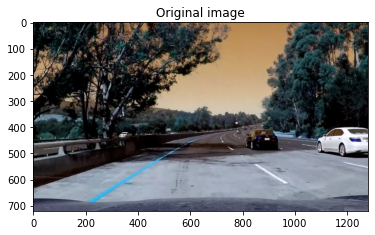

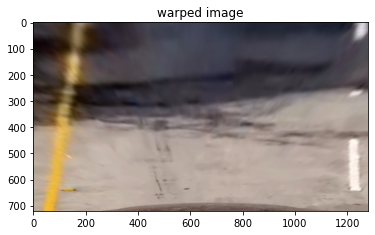

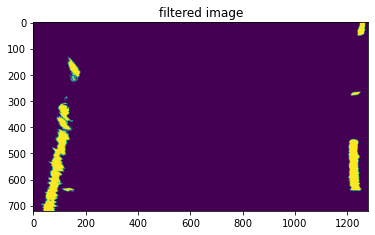

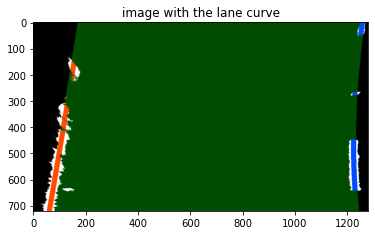

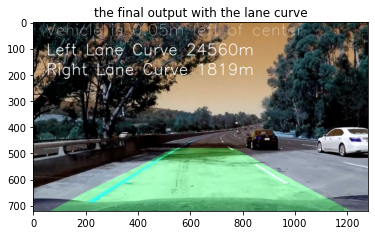

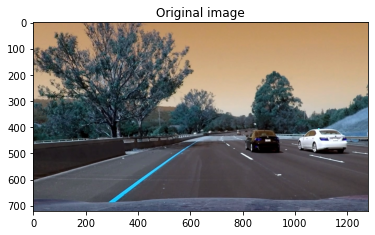

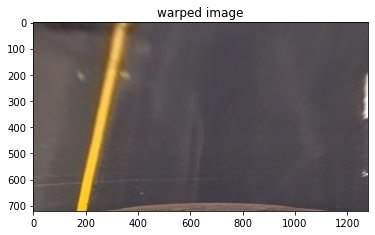

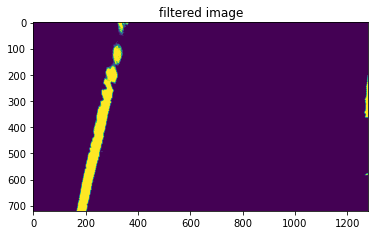

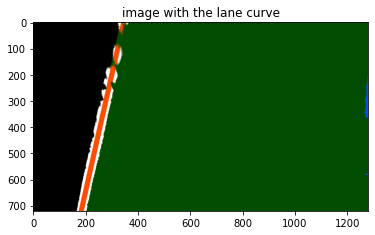

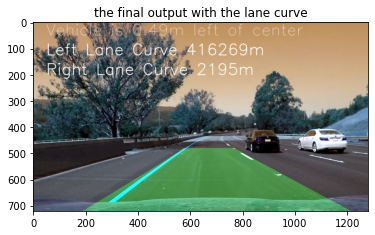

In [12]:
for imgname in os.listdir("test_images/"):
    image =cv2.imread('test_images/' + imgname)
    img = transform(image, M)
    img = cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB)
    img2 = img
    img = sharpen_img(img)
    #img = eq_Hist(img)
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
   
    
    
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    canny = cv2.Canny(gray, 20, 120)
    '''
    #result = pipeline(img)
    result = img_col_sel(img)
    out_img, out_img2 = search_around_poly(result, image)

    plt.figure()
    plt.title("Original image")
    plt.imshow(image)
    plt.figure()
    plt.title("warped image")
    plt.imshow(img2)
    
    plt.figure()
    plt.title("filtered image")
    plt.imshow(result)
    plt.figure()
    plt.title("image with the lane curve")
    plt.imshow(out_img)
    plt.figure()
    plt.title("the final output with the lane curve")
    plt.imshow(out_img2)

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #image = cv2.cvtColor(undistort(image), cv2.COLOR_BGR2RGB)
    img = transform(image, M)
    
    img = sharpen_img(img)
    result = img_col_sel(img)
    result = sharpen_img(result)
    try:
        out_img, out_img2 = search_around_poly(result, image)
        return out_img2
    except:
        return image

    

In [15]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 5min 5s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))